In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas

In [3]:
%%R -o regions 
library(tidyr)
library(dplyr)
read.delim("../data/pan_MM_differential_ATAC-seq_regions.tsv") %>%
    gather("key", "value", -id, -baseMean) %>%
    separate(id, into=c("chr", "start", "end")) -> regions

/shared/conda-install/envs/cgat-devel-lite/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/shared/conda-install/envs/cgat-devel-lite/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/shared/conda-install/envs/cgat-devel-lite/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


In [4]:
%%R -o regions
write.table(regions[,c("chr", "start", "end")], "../data/sig_atac_reigons.bed", row.names=F, col.names=F,
           quote=F, sep="\t")

In [5]:
%%bash --out diff_transcripts
zcat /shared/sudlab1/General/annotations/hg38_ensembl85/geneset.dir/coding_transript_tss.bed.gz \
| sort -k1,1 -k2,2n \
| bedtools slop -l 2000 -r 100 \
           -s \
           -g /shared/sudlab1/General/annotations/hg38_ensembl85/assembly.dir/contigs.tsv \
           -i - \
| bedtools intersect -u \
   -a - \
   -b ../data/sig_atac_reigons.bed \
| cut -f 4

In [6]:
diff_transcripts = diff_transcripts.split("\n")

In [7]:
len(diff_transcripts)

40579

In [8]:
import CGAT.Database as D
tx2gene = D.fetch_DataFrame("SELECT DISTINCT transcript_id, gene_id FROM transcript_info",
                           "/shared/sudlab1/General/annotations/hg38_ensembl85/csvdb")
tx2gene.shape

(197935, 2)

In [9]:
%%R
summary(regions$log2FoldChange)

Length  Class   Mode 
     0   NULL   NULL 


In [10]:
diff_genes = tx2gene.gene_id[tx2gene.transcript_id.isin(diff_transcripts)].unique()
diff_genes.shape

(7193,)

In [11]:
%%R -i diff_genes
gene_de <- read.delim("../data/pan_MM_differential_genes.tsv", stringsAsFactors=FALSE) %>%
           right_join(read.delim("/shared/sudlab1/General/annotations/hg38_ensembl85/geneset.dir/coding_gene_tts.bed.gz",
                       stringsAsFactors=FALSE, header=F), by =c("id"= "V4")) %>%
                       select(id:GENENAME)
head(gene_de)


               id baseMean log2FoldChange     lfcSE     stat      pvalue
1 ENSG00000186092       NA             NA        NA       NA          NA
2 ENSG00000279928       NA             NA        NA       NA          NA
3 ENSG00000279457       NA             NA        NA       NA          NA
4 ENSG00000278566       NA             NA        NA       NA          NA
5 ENSG00000273547       NA             NA        NA       NA          NA
6 ENSG00000187634 223.6664       2.367868 0.7945055 2.980304 0.002879621
        padj DE_MM_vs_ND SYMBOL                                 GENENAME
1         NA          NA   <NA>                                     <NA>
2         NA          NA   <NA>                                     <NA>
3         NA          NA   <NA>                                     <NA>
4         NA          NA   <NA>                                     <NA>
5         NA          NA   <NA>                                     <NA>
6 0.06673067           1 SAMD11 sterile alpha motif

In [12]:
%%R -i diff_genes
library(tidyr)
library(dplyr)
all_genes <- read.delim("/shared/sudlab1/General/annotations/hg38_ensembl85/geneset.dir/coding_gene_tts.bed.gz",
                       stringsAsFactors=FALSE, header=F)$V4
gene_de %>% 
  mutate(padj=!is.na(padj),
            lfc = ifelse(is.na(log2FoldChange), 0, log2FoldChange),
            log2FoldChange=abs(lfc) > 1, 
           ) %>%
  mutate(sig = padj & log2FoldChange, dir = ifelse(lfc<0, "Down", "Up"), 
         promoter=id %in% diff_genes) -> gene_de2

head(gene_de2)

               id baseMean log2FoldChange     lfcSE     stat      pvalue  padj
1 ENSG00000186092       NA          FALSE        NA       NA          NA FALSE
2 ENSG00000279928       NA          FALSE        NA       NA          NA FALSE
3 ENSG00000279457       NA          FALSE        NA       NA          NA FALSE
4 ENSG00000278566       NA          FALSE        NA       NA          NA FALSE
5 ENSG00000273547       NA          FALSE        NA       NA          NA FALSE
6 ENSG00000187634 223.6664           TRUE 0.7945055 2.980304 0.002879621  TRUE
  DE_MM_vs_ND SYMBOL                                 GENENAME      lfc   sig
1          NA   <NA>                                     <NA> 0.000000 FALSE
2          NA   <NA>                                     <NA> 0.000000 FALSE
3          NA   <NA>                                     <NA> 0.000000 FALSE
4          NA   <NA>                                     <NA> 0.000000 FALSE
5          NA   <NA>                                     <NA> 

In [13]:
%%R
table(gene_de2$padj)


FALSE  TRUE 
19232   725 


In [14]:
%R table(gene_de2$promoter)

array([12764,  7193], dtype=int32)

In [15]:
%%R
with(gene_de2, table(ifelse(sig, dir, "Not"), promoter))


      promoter
       FALSE  TRUE
  Down   121     9
  Not  12300  6932
  Up     343   252


In [16]:
252.0/(6932+252+9), 343/(12300+121+343)

(0.035034060892534406, 0)

In [17]:
%%R
with(gene_de2,fisher.test(sig & dir=="Up", promoter))


	Fisher's Exact Test for Count Data

data:  sig & dir == "Up" and promoter
p-value = 0.001323
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.109942 1.555682
sample estimates:
odds ratio 
  1.314691 



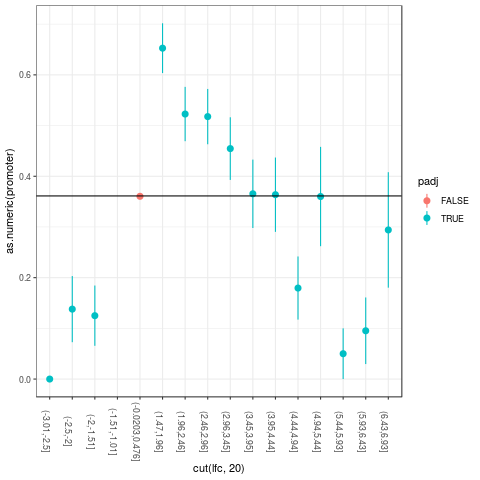

In [18]:
%%R
library(ggplot2)
gene_de2 %>%

   filter(lfc > -3 & lfc <7) %>%
   ggplot() + 
   aes(x=cut(lfc,20), y=as.numeric(promoter), col=padj) +
   stat_summary(fun.y=mean, 
                fun.ymin=function(a) mean(a) - sd(a)/sqrt(length(a)),
                fun.ymax=function(a) mean(a) + sd(a)/sqrt(length(a))) +
   geom_hline(yintercept=sum(na.omit(gene_de2)$promoter)/dim(na.omit(gene_de2))[1]) + 
   theme_bw() +
   theme(axis.text.x=element_text(angle=-90))  

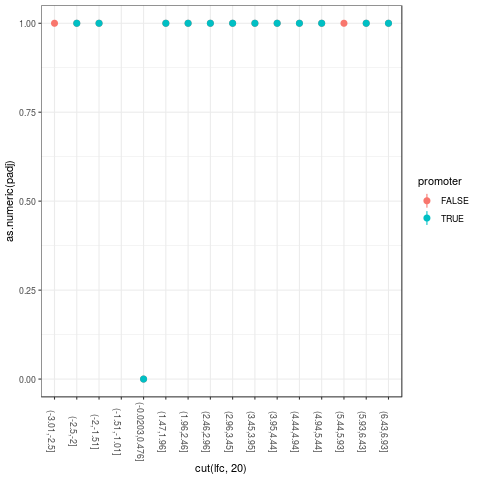

In [19]:
%%R
gene_de2 %>%
 
filter(lfc > -3 & lfc <7) %>%
   ggplot() +
   aes(x=cut(lfc,20),  y=as.numeric(padj), col=promoter) +
   stat_summary(fun.y=mean, 
                fun.ymin=function(a) mean(a) - sd(a)/sqrt(length(a)),
                fun.ymax=function(a) mean(a) + sd(a)/sqrt(length(a))) +

   theme_bw() +
   theme(axis.text.x=element_text(angle=-90))  

In [20]:
%%R
m <- glm(I(sig & dir=="Up") ~  promoter , data=filter(gene_de2), family="binomial")
summary(m)


Call:
glm(formula = I(sig & dir == "Up") ~ promoter, family = "binomial", 
    data = filter(gene_de2))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.2671  -0.2671  -0.2334  -0.2334   2.6895  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -3.58941    0.05474 -65.578  < 2e-16 ***
promoterTRUE  0.27364    0.08431   3.246  0.00117 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5352.3  on 19956  degrees of freedom
Residual deviance: 5341.9  on 19955  degrees of freedom
AIC: 5345.9

Number of Fisher Scoring iterations: 6



# Enhancers


In [21]:
import os

In [22]:
%%bash --out oe_atac_per_gene
cat ../data/pan_MM_differential_ATAC-seq_regions_no_TSS.tsv \
|  awk -v FS='[#\t]' -v OFS='\t' '$5>0' \
|  cut -f1-3 \
|  tail -n +2 \
| gzip > ../data/pan_myloma_OE_atac_no_TSS.bed.gz

zcat /shared/sudlab1/General/annotations/hg38_ensembl85/geneset.dir/coding_gene_tss.bed.gz \
| bedtools slop -l 500000 -r 500000 \
       -g /shared/sudlab1/General/annotations/hg38_ensembl85/assembly.dir/contigs.tsv \
| bedtools intersect -c -a - -b ../data/pan_myloma_OE_atac_no_TSS.bed.gz | cut -f4,7 


In [23]:
oe_atac_per_gene = pandas.DataFrame([[x.split("\t")[0], int(x.split("\t")[1])] for x in oe_atac_per_gene.split("\n")[:-1]],
                                   columns=["gene_id", "OE_ATAC"])


In [24]:
oe_atac_per_gene.dtypes

gene_id    object
OE_ATAC     int64
dtype: object

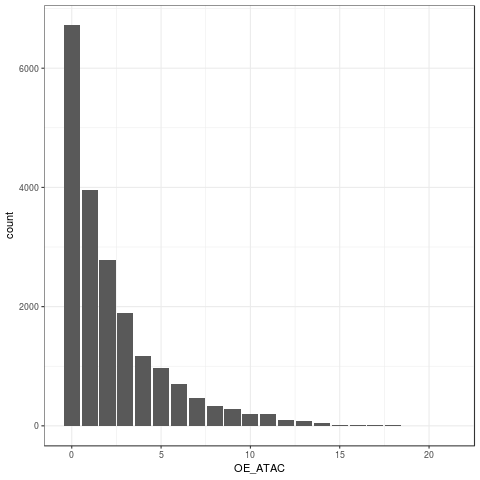

In [25]:
%%R -i oe_atac_per_gene
library(ggplot2)
ggplot(oe_atac_per_gene) + aes(x=OE_ATAC) +
   geom_bar() + theme_bw()

In [26]:
%%R
gene_de2 %>% inner_join(oe_atac_per_gene, by=c("id"="gene_id")) -> gene_de3

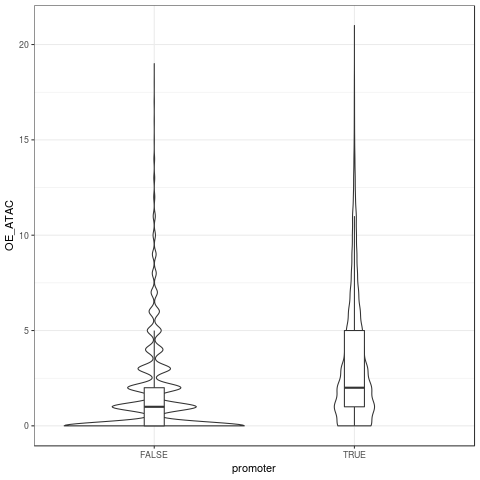

In [27]:
%%R

ggplot(gene_de3) + aes(x=promoter, y=OE_ATAC) +
  geom_violin() +
  geom_boxplot(width=0.1, outlier.shape=NA) +
  theme_bw()

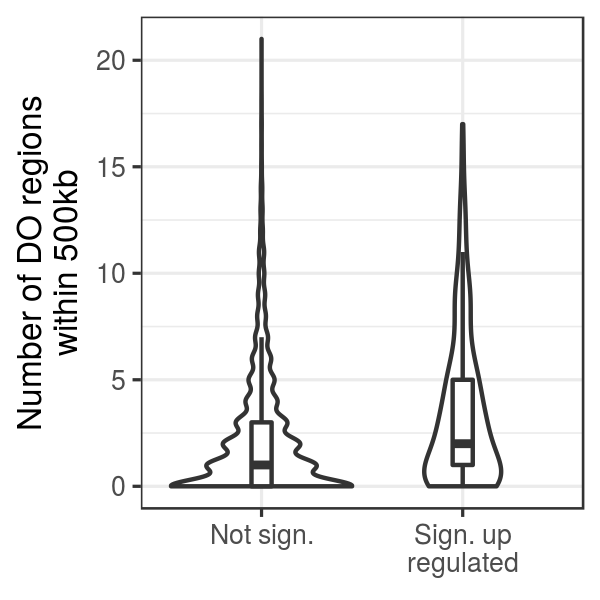

In [28]:
%%R -h 2 -w 2 -u in -r 300
 ggplot(gene_de3) + aes(x=sig & dir=="Up", y = OE_ATAC) +
   geom_violin(adjust=1.3) +
   geom_boxplot(width=0.1, outlier.shape=NA) +
   ylab("Number of DO regions\nwithin 500kb") +
   scale_x_discrete(name=NULL, labels=c( "Not sign.", "Sign. up\nregulated")) +
   theme_bw(base_size=8) -> g
ggsave("../Figures/figure1S.png", g, width=2, height=2, dpi=300)
print(g)

In [29]:
%%R
with(gene_de3, table(ifelse(sig, dir, "Not"), OE_ATAC>0))

      
       FALSE  TRUE
  Down    60    70
  Not   6520 12712
  Up     137   458


In [30]:
137/(6520+60+137), 458/(12712+458+70)

(0, 0)

In [31]:
%%R
with(gene_de3, fisher.test(sig & dir=="Up", OE_ATAC >0))


	Fisher's Exact Test for Count Data

data:  sig & dir == "Up" and OE_ATAC > 0
p-value = 1.152e-08
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.415409 2.103351
sample estimates:
odds ratio 
  1.720922 



In [32]:
%%R
m <- glm(I(sig & dir=="Up") ~  OE_ATAC + promoter, data=gene_de3, family="binomial")
print(summary(m))
print(anova(m, test="Chisq"))


Call:
glm(formula = I(sig & dir == "Up") ~ OE_ATAC + promoter, family = "binomial", 
    data = gene_de3)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6599  -0.2531  -0.2267  -0.2085   2.7712  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -3.81797    0.06217 -61.411   <2e-16 ***
OE_ATAC       0.11173    0.01179   9.480   <2e-16 ***
promoterTRUE  0.05791    0.08835   0.655    0.512    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5352.3  on 19956  degrees of freedom
Residual deviance: 5264.2  on 19954  degrees of freedom
AIC: 5270.2

Number of Fisher Scoring iterations: 6

Analysis of Deviance Table

Model: binomial, link: logit

Response: I(sig & dir == "Up")

Terms added sequentially (first to last)


         Df Deviance Resid. Df Resid. Dev Pr(>Chi)    
NULL                     19956     5352.3             
OE_ATAC   1   

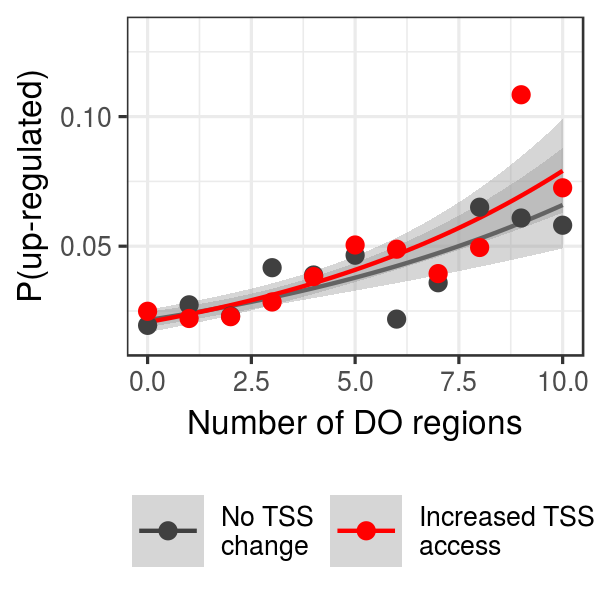

In [42]:
%%R -h 2 -w 2 -u in -r 300
gene_de3 %>%
   mutate(OE_ATAC = ifelse(OE_ATAC > 10, 10, OE_ATAC)) %>%
   ggplot() + 
   aes(x=OE_ATAC, 
       y=as.numeric(sig & dir=="Up"),
       col=promoter, group=promoter) +
#   stat_summary(y.fun=mean, 
#                ymin.fun=function(a) mean(a) - 2*sd(a)/sqrt(len(a)), 
#                ymax.fun=function(b) mean(a) + 2*sd(a)/sqrt(len(a)),
#                geom="ribbon", alpha=0.1, col=NA
#                 ) +
  # stat_summary(y.fun=mean, geom="line", size=1,alpha=0.5) +
   geom_smooth(method="glm", method.args = list(family="binomial"), size=0.5) + 
   stat_summary(y.fun=mean, geom="point", size=1.5) +
   xlab("Number of DO regions") +
   ylab("P(up-regulated)") +
   scale_color_manual(name=NULL, 
                      labels=c("FALSE"="No TSS\nchange", 
                               "TRUE"="Increased TSS\naccess"),
                     values=c("FALSE"="grey25",
                              "TRUE"="red")) +
   theme_bw(base_size=8) +
   theme(legend.position="bottom") -> g
ggsave("../Figures/fig 1S3.png", g, height=2, width=2, dpi=300)
print(g)
    

In [34]:
%%bash --out distance_to_oe

bedtools closest -a /shared/sudlab1/General/annotations/hg38_ensembl85/geneset.dir/coding_gene_tss.bed.gz \
                 -b ../data/pan_myloma_OE_atac_no_TSS.bed.gz \
                 -d \
| cut -f 4,10 

In [35]:
distance_to_oe = pandas.DataFrame([x.split("\t") for x in distance_to_oe.split("\n")[:-1]],
                                 columns=["gene_id", "distance_to_oe"])
distance_to_oe.dtypes

gene_id           object
distance_to_oe    object
dtype: object

In [36]:
distance_to_oe.distance_to_oe = distance_to_oe.distance_to_oe.astype("int64")

In [37]:
%%R -i distance_to_oe
gene_de4 <- gene_de3 %>% inner_join(distance_to_oe, by=c("id"="gene_id"))
head(gene_de4)

               id baseMean log2FoldChange     lfcSE     stat      pvalue  padj
1 ENSG00000186092       NA          FALSE        NA       NA          NA FALSE
2 ENSG00000279928       NA          FALSE        NA       NA          NA FALSE
3 ENSG00000279457       NA          FALSE        NA       NA          NA FALSE
4 ENSG00000278566       NA          FALSE        NA       NA          NA FALSE
5 ENSG00000273547       NA          FALSE        NA       NA          NA FALSE
6 ENSG00000187634 223.6664           TRUE 0.7945055 2.980304 0.002879621  TRUE
  DE_MM_vs_ND SYMBOL                                 GENENAME      lfc   sig
1          NA   <NA>                                     <NA> 0.000000 FALSE
2          NA   <NA>                                     <NA> 0.000000 FALSE
3          NA   <NA>                                     <NA> 0.000000 FALSE
4          NA   <NA>                                     <NA> 0.000000 FALSE
5          NA   <NA>                                     <NA> 

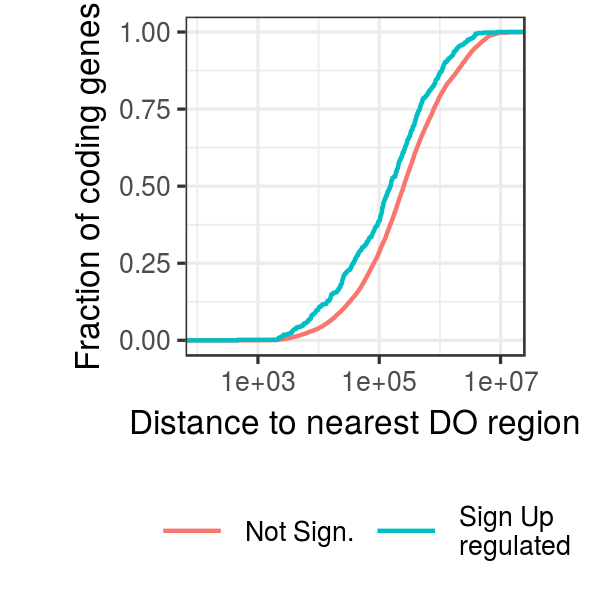

In [38]:
%%R -w 2 -h 2 -r 300 -u in
ggplot(gene_de4) + aes(col=sig & dir=="Up", x=distance_to_oe) +
   stat_ecdf() +
   scale_x_continuous(trans="log10") +
   theme_bw(base_size=8) +
   scale_color_discrete(labels=c("Not Sign.", "Sign Up\nregulated"), name=NULL) +
   theme(legend.position = "bottom", aspect.ratio=1) +
   xlab("Distance to nearest DO region") + 
   ylab("Fraction of coding genes") -> g

ggsave("../Figures/Figure1S2.png", g, width=2, height=2, dpi=300)
print(g)

In [39]:
%%R 
with(gene_de4, aggregate(distance_to_oe, by=list(sig & dir=="Up"), FUN=summary))

  Group.1     x.Min.  x.1st Qu.   x.Median     x.Mean  x.3rd Qu.     x.Max.
1   FALSE       -1.0    79943.5   251074.0   820844.3   789137.5 13926941.0
2    TRUE      461.0    37716.0   153467.0   457824.7   464975.0  8664845.0


In [40]:
%%R
with(gene_de4, aggregate(OE_ATAC, by=list(sig & dir=="Up"), FUN=summary))

  Group.1    x.Min. x.1st Qu.  x.Median    x.Mean x.3rd Qu.    x.Max.
1   FALSE  0.000000  0.000000  1.000000  2.246772  3.000000 21.000000
2    TRUE  0.000000  1.000000  2.000000  3.472269  5.000000 17.000000


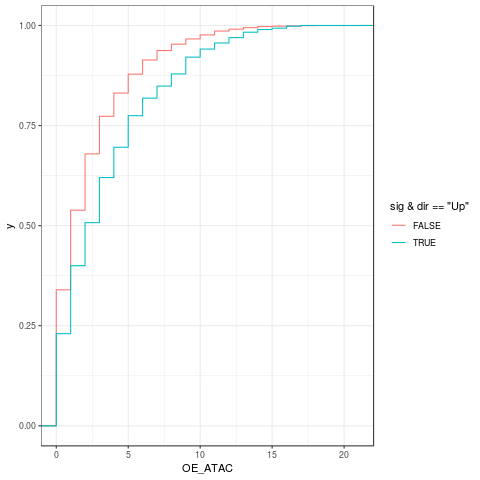

In [41]:
%%R
ggplot(gene_de4) + aes(col=sig & dir=="Up", x=OE_ATAC) +
   stat_ecdf() +
   scale_x_continuous() +
   theme_bw()